In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

#% matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving train_10k.txt to train_10k.txt


In [5]:
# Upload the train file from your local drive
from google.colab import files
uploaded = files.upload()

Saving val_1k.txt to val_1k.txt


In [6]:
import pandas as pd

labels = []
sentences = []

# Read the file line by line
with open("train_10k.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith("__label__"):
            parts = line.split(" ", 1)
            if len(parts) != 2:
                continue
            label = parts[0].replace("__label__", "")
            sentence = parts[1]
            labels.append(label)
            sentences.append(sentence)

# Make DataFrame
df = pd.DataFrame({"label": labels, "sentence": sentences})



In [7]:
import pandas as pd

val_labels = []
val_sentences = []

# Read val_1k.txt line by line
with open("val_1k.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith("__label__"):
            parts = line.split(" ", 1)
            if len(parts) != 2:
                continue
            label = parts[0].replace("__label__", "")
            sentence = parts[1]
            val_labels.append(label)
            val_sentences.append(sentence)

# Create DataFrame
val_df = pd.DataFrame({"label": val_labels, "sentence": val_sentences})

# Preview
print(val_df.shape)
val_df.sample(5)


(1000, 2)


,label,sentence
751,Sanskrit,adya prathamavaaram dhavitavan .
292,Kashmiri,"chaayn athe. "" meyi haayv adaaltas manz paneyn..."
217,Other,Il ruolo del governo - ha sottolineato - è que...
202,Marathi,catayan mhanje dhana prabharit aayan ( jyamadh...
441,Kannada,Sussexnallina cricket bagegina modala spashtav...


In [8]:
df.shape

(10000, 2)

In [9]:
df.sample(10)

,label,sentence
5141,Kashmiri,zaati jyet ayer chaartar parwaz neoyarak jarsi...
5445,Nepali,sohi karan paryatan prawardhanka lagi purwadha...
4369,Gujarati,aevu manvama aave chhe keey teey kshamata vadh...
1087,Sindhi,sukhar shaher taeluqo pakistan jee soobi sindh...
8866,Bodo,ing 2010 maitayao oxfwrdah bitangkwo oxfwrd mu...
6361,Manipuri_Mei,100suba indiagi asuppa chatna - kaanglongi sem...
6022,Bodo,biyw jiu somaj desh buhum mansikwo
1483,Sindhi,"payal peer jee , gajee munjhh ghabar"
7649,Sindhi,sifarati umlo
1114,Kannada,hosa maney khareedisida arjun kapoor mattu mal...


In [10]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print("Tokenize the first sentence:")
print(tokenized_texts[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize the first sentence:
['ai', '##see', 'bach', '##at', 'ham', '##ein', 'una', 'st', '##hiti', '##yon', 'mein', 'b', '##hee', 'sa', '##ha', '##aya', '##ta', 'kara', '##ti', 'hay', '##e', ',', 'ja', '##ba', 'hum', '##m', 'kam', '##ai', 'kara', '##ne', 'mein', 'sa', '##ksha', '##m', 'nah', '##een', 'hot', '##ey', 'hai', '##n', ',', 'ud', '##aa', '##hara', '##n', 'key', 'li', '##ye', 'se', '##va', '##ani', '##vr', '##itt', '##i', 'key', 'ba', '##ad', '.']


In [11]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

In [12]:
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts], maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

print(input_ids)
input_ids.shape

[[ 9932 19763 10384 ...     0     0     0]
 [ 1047 14672 11231 ...     0     0     0]
 [28616  5802  1024 ...     0     0     0]
 ...
 [ 6643 19466  2063 ...     0     0     0]
 [13360  7221  2638 ...     0     0     0]
 [ 1000  1999  2075 ...     0     0     0]]


(10000, 128)

In [13]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
print(input_ids)

[[9932, 19763, 10384, 4017, 10654, 12377, 14477, 2358, 27798, 14001, 24182, 1038, 21030, 7842, 3270, 12186, 2696, 13173, 3775, 10974, 2063, 1010, 14855, 3676, 14910, 2213, 27829, 4886, 13173, 2638, 24182, 7842, 28132, 2213, 20976, 12129, 2980, 3240, 15030, 2078, 1010, 20904, 11057, 11077, 2078, 3145, 5622, 6672, 7367, 3567, 7088, 19716, 12474, 2072, 3145, 8670, 4215, 1012], [1047, 14672, 11231, 20697, 3511, 11057, 10139, 25212, 2063, 21862, 19722, 12849, 21325, 2321, 13075, 21010, 1006, 10975, 11057, 3148, 24667, 5339, 15222, 1007, 9779, 5283, 13344, 2140, 20298, 13955, 4779, 10606, 2819, 2753, 11382, 4135, 2080, 14397, 26415, 1013, 4012, 24667, 3367, 1013, 17410, 3567, 11748, 18222, 3669, 2140, 4521, 10222, 3211, 12942, 2006, 19172, 3156, 1024, 5539, 1024, 2531, 13250, 22827, 4817, 3211, 2140, 10958, 16782, 10175, 11431, 2819, 6583, 26518, 13129, 1012], [28616, 5802, 1024, 14163, 2015, 4478, 2094, 6583, 2497, 5737, 15333, 2063, 1053, 12069, 15878, 7632, 19658, 2604, 17170, 5622, 10023

In [15]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
print(input_ids)

[[ 9932 19763 10384 ...     0     0     0]
 [ 1047 14672 11231 ...     0     0     0]
 [28616  5802  1024 ...     0     0     0]
 ...
 [ 6643 19466  2063 ...     0     0     0]
 [13360  7221  2638 ...     0     0     0]
 [ 1000  1999  2075 ...     0     0     0]]


In [16]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [17]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [18]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numeric
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)  # int64 array
validation_labels = label_encoder.transform(validation_labels)  # int64 array


In [19]:
num_labels = len(label_encoder.classes_)
print(num_labels)

22


In [20]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [21]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [22]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=22)
model.cuda()

100%|██████████| 407873900/407873900 [00:37<00:00, 10813675.61B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

In [23]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [24]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

In [25]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):


  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()


    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))


  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 1.9781755800788283


Epoch:  25%|██▌       | 1/4 [03:38<10:56, 218.92s/it]

Validation Accuracy: 0.5068359375
Train loss: 0.9061189207202154


Epoch:  50%|█████     | 2/4 [07:22<07:22, 221.39s/it]

Validation Accuracy: 0.755859375
Train loss: 0.45587364602701885


Epoch:  75%|███████▌  | 3/4 [11:05<03:42, 222.27s/it]

Validation Accuracy: 0.845703125
Train loss: 0.2654535463013759


Epoch: 100%|██████████| 4/4 [14:48<00:00, 222.21s/it]

Validation Accuracy: 0.8623046875


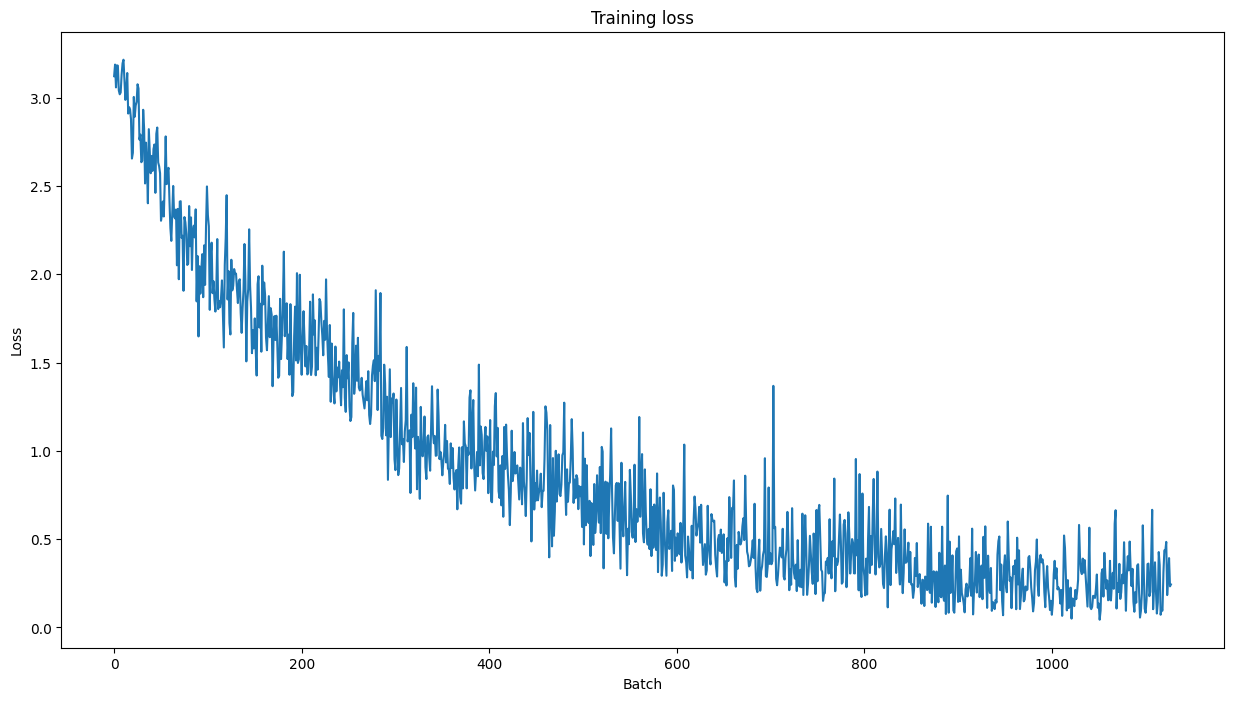

In [27]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [29]:
# Create sentence and label lists
sentences = val_df.sentence.values
labels = val_df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print("Tokenize the first sentence:")
print(tokenized_texts[0])

MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

# Convert string labels to numeric
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # int64 array


prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

batch_size = 32


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Tokenize the first sentence:
['ka', '##af', '##i', ',', 'das', 'es', '##hari', '##ya', 'ch', '##he', 'fai', '##sa', '##d']


In [30]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [31]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [32]:
matthews_set

[np.float64(0.6781308865783844),
 np.float64(0.7382995434594364),
 np.float64(0.7038216560509554),
 np.float64(0.7696390658174098),
 np.float64(0.7078537912085662),
 np.float64(0.7707714481520318),
 np.float64(0.8359830485520526),
 np.float64(0.8408381573084004),
 np.float64(0.6765320049192765),
 np.float64(0.8012793112060708),
 np.float64(0.7667458144544337),
 np.float64(0.8375335674770997),
 np.float64(0.8697498184952911),
 np.float64(0.803654626357913),
 np.float64(0.7722052282665806),
 np.float64(0.8361702127659575),
 np.float64(0.8374040812260385),
 np.float64(0.6316362431582867),
 np.float64(0.709609688133084),
 np.float64(0.8063496578202646),
 np.float64(0.7400851201091491),
 np.float64(0.7068818689022419),
 np.float64(0.7714901649702074),
 np.float64(0.7722457627118644),
 np.float64(0.8360000068157963),
 np.float64(0.8062867008021762),
 np.float64(0.673773987206823),
 np.float64(0.6781642516906499),
 np.float64(0.8363068612550038),
 np.float64(0.6719805805384007),
 np.float64(0

In [33]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


In [34]:
matthews_corrcoef(flat_true_labels, flat_predictions)

np.float64(0.762114428160489)